# Assignment 2

Author: [Lucas David](http://github.com/lucasdavid)  
This notebook can be downloaded at https://github.com/lucasdavid/mo850/

## Small data set 1 non paired

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import scikits.bootstrap as bootstrap
import statsmodels.stats.contingency_tables

import matplotlib
from matplotlib import pyplot

%matplotlib inline


def exact_mc_perm_test(xs, ys, nmc):
    # Originally implemented at:
    # https://stackoverflow.com/questions/24795535
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc

In [2]:
a1, b1 = '../data/a1.csv', '../data/b1.csv'
a1, b1 = (pd.read_csv(d, header=None).values for d in (a1, b1))
g = np.random.normal(size=max(len(a1), len(b1)))

print('a1:', a1.mean(), a1.std())
print('b1:', b1.mean(), b1.std())
print('g:', g.mean(), g.std())

a1: 7.995025006588539 4.874042455416288
b1: 5.064099812088535 2.8397393721530735
g: 0.41312219627125435 1.1009166446947019


In [3]:
s, p = (e[0] for e in stats.ttest_ind(a1, b1, equal_var=True))
print('p-value from equal-variance t-test:', p)

s, p = (e[0] for e in stats.ttest_ind(a1, b1, equal_var=False))
print('p-value from Wetch\'s test:', p)

s, p = stats.ranksums(a1, b1)
print('p-value from Wilcoxon rank sum test:', p)

p = exact_mc_perm_test(a1, b1, nmc=5000)
print('p-value from monte-carlo permutation test:', p)

p-value from equal-variance t-test: 0.0375853561701041
p-value from Wetch's test: 0.057238709334717516
p-value from Wilcoxon rank sum test: 0.06675301516963451
p-value from monte-carlo permutation test: 0.0382


## paired data set 1

In [4]:
d = pd.read_csv('../data/paired.csv', header=None, names=['a', 'b'])

In [5]:
s, p = stats.ttest_rel(d['a'], d['b'])
print('p-value from paired t-test:', p)

s, p = stats.ttest_ind(d['a'], d['b'])
print('p-value from t-test:', p)

s, p = stats.wilcoxon(d['a'], d['b'])
print('p-value from Wilcoxon signed rank-test:', p)

s, p = stats.ranksums(d['a'], d['b'])
print('p-value from Wilcoxon rank sums test:', p)

p = exact_mc_perm_test(d['a'], d['b'], nmc=5000)
print('p-value from monte-carlo permutation test:', p)

p-value from paired t-test: 0.004650123707777353
p-value from t-test: 0.1366049915156075
p-value from Wilcoxon signed rank-test: 0.012515318690073973
p-value from Wilcoxon rank sums test: 0.18587673236587576
p-value from monte-carlo permutation test: 0.144


## Confidence Intervals

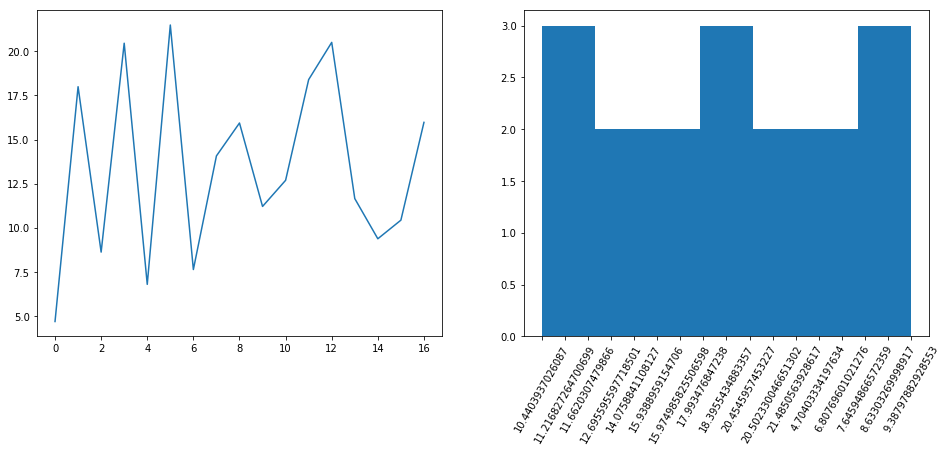

In [6]:
d = pd.read_csv('../data/single.csv', header=None, names=['measure'])

pyplot.figure(figsize=(16, 6))
pyplot.subplot(1, 2, 1)
_ = pyplot.plot(d)
pyplot.subplot(1, 2, 2)
_ = pyplot.hist(d, bins=7)
_ = pyplot.xticks(rotation=60)

In [7]:
a, b = map(float, stats.t.interval(0.95, len(d) - 1,
                                   loc=np.mean(d),
                                   scale=stats.sem(d)))
print('confidence interval for using the mean: (%.2f, %.2f)' % (a, b))

a, b = map(float, stats.t.interval(0.95, len(d) - 1,
                                   loc=np.median(d),
                                   scale=stats.sem(d)))
print('confidence interval for using the median: (%.2f, %.2f)' % (a, b))

# Originally implemented at:
# github.com/cgevans/scikits-bootstrap/blob/master/scikits/bootstrap/bootstrap.py
a, b = map(float, bootstrap.ci(data=d,
                               statfunction=np.mean,
                               n_samples=10000))
print('confidence interval using bootstrap/mean: (%.2f, %.2f)' % (a, b))

confidence interval for using the mean: (10.74, 16.09)
confidence interval for using the median: (10.02, 15.37)
confidence interval using bootstrap/mean: (11.06, 15.85)


##  Significance test for categoric data

In [8]:
d = pd.read_csv('../data/two.csv', header=None, names=['a', 'b'])
print(d.head())
print('a and b correlation/p-value:', stats.pearsonr(d['a'], d['b']))

   a  b
0  1  1
1  1  1
2  1  0
3  0  1
4  1  1
a and b correlation/p-value: (0.29963227720692476, 0.06760935472787508)


In [9]:
rc_table = pd.crosstab(d['a'], d['b'])
print('R x C table:', rc_table, sep='\n')

_, p, _, _ = stats.chi2_contingency(rc_table)
print('p-value from chi-squared test:', p)

p = statsmodels.stats.contingency_tables.mcnemar(rc_table).pvalue
print('p-value from mcnemar test:', p)

s, p = stats.ttest_rel(d['a'], d['b'])
print('p-value from paired t-test:', p)

s, p = stats.wilcoxon(d['a'], d['b'])
print('p-value from Wilcoxon signed rank-test:', p)

R x C table:
b  0   1
a       
0  8   9
1  4  17
p-value from chi-squared test: 0.1346232992876426
p-value from mcnemar test: 0.26684570312499983
p-value from paired t-test: 0.16854520829809697
p-value from Wilcoxon signed rank-test: 0.16551785869747015


I'm not quite sure which one should be considered here.

Chi-squared requires independence from data [1](http://yatani.jp/teaching/doku.php?id=hcistats:chisquare).

*Independence implies zero correlation => non-zero correlation implies dependency*

The fact that `stats.pearsonr` gave me *corr=29.96%* and *p-value=6.7%* indicates that we cannot assume independency here, but it's [docstring](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) mentions these value become reasonable for datasets of 500 samples or more, which is clearly not the case here.

According to its [wiki](https://en.wikipedia.org/wiki/McNemar%27s_test), McNemar's test is not suited for when tables with *c + b < 25*. This is the case here, as *c=4* and *b=9*.

This [researchgate post](https://www.researchgate.net/post/Can_McNemars_test_be_done_when_one_of_the_cell_value_is_0_in_the_2x2_contingency_table) mentions Wilcoxon's signed-rank test can be applied as long as your data is binary, which is our case.